<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time

import warnings

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, cross_val_score

In [3]:
# отключим некритические предупреждения в коде

warnings.filterwarnings("ignore")

In [4]:
# объяивим глобальную переменную для дальнейшего использования

STATE = np.random.RandomState(42)

In [5]:
# загрузим наш файл и установим дату в качестве индекса

try:
    data = pd.read_csv('/Users/alex/Downloads/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [6]:
# сделаем копию, для возможности использования в дальнейшем

data_orig = data.copy(deep = True)

In [7]:
# ознакомимся и выведем хед

data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [8]:
data.shape

(26496, 1)

In [7]:
# нет ли пропусков

data.isna().sum()

num_orders    0
dtype: int64

In [8]:
# дубликаты

data.index.duplicated().sum()

0

In [9]:
# взглянем на размер

data.shape

(26496, 1)

In [10]:
# проверим упорядочены наши индексы/даты

data.index.is_monotonic

True

In [11]:
# сделаем ресемплинг по одному часу в качесте функции укажем сумму

data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


__Ознокомились с данными, пропусков и дублей не обнаружено, проверили упарядочены ли данные, после чего сделали ресемплирование по одному часу.__

## Анализ

In [12]:
# взгялем за какой переод представленны данныые 

print(f'Период данных начинается с {data.index.min()},и по {data.index.max()}')


Период данных начинается с 2018-03-01 00:00:00,и по 2018-08-31 23:00:00


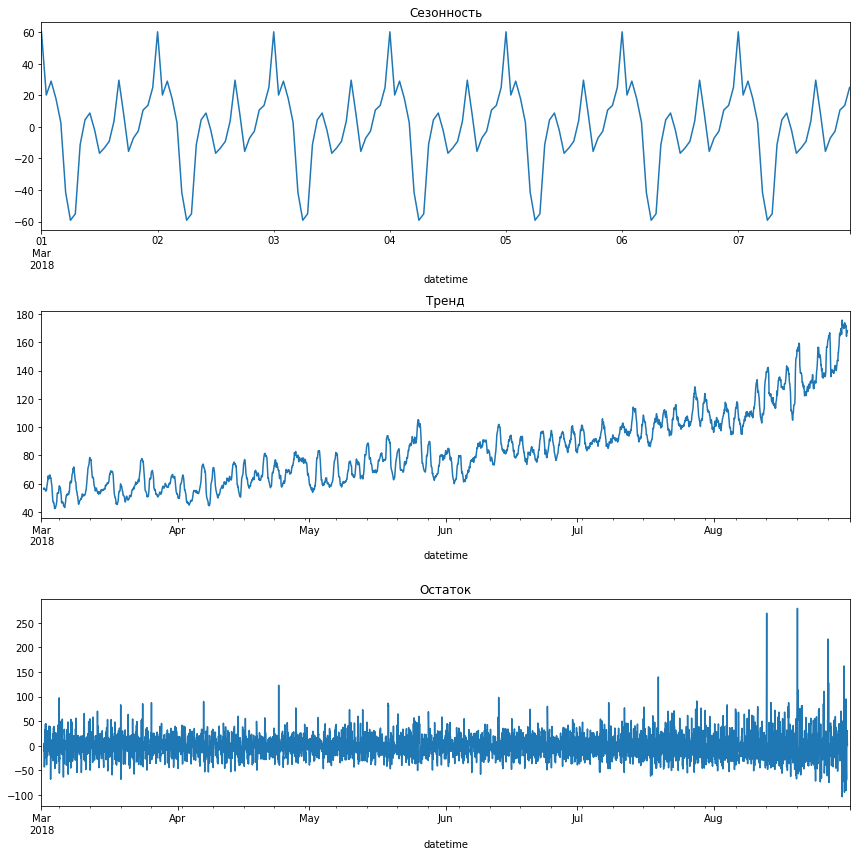

In [13]:
# Выведем графики сезонности и трендов и остатка

decomposed = seasonal_decompose(data)
 
plt.figure(figsize = (12, 12)) 
plt.subplot(311)


decomposed.seasonal['2018-03-01':'2018-03-07'].plot(ax = plt.gca())
plt.title('Сезонность')
plt.subplot(312)

decomposed.trend.plot(ax = plt.gca())
plt.title('Тренд')
plt.subplot(313)

decomposed.resid.plot(ax = plt.gca())
plt.title('Остаток')
plt.tight_layout()

Можно заметить, что сезонность проявляется ежедневно - ночное время является пиковым по кол-ву заказов такси. Так же мы видим ростущий тренд, скорее всего эт освязанно с летним периодом времени, когда люди уходят в отпуска , к сожалею дальше трудно сказать т.к данные которые мы имеем всего за полгода.

## Обучение

Создадим функцию, которая будет добавлять признаки, делить нашу выборку, обучать деревянную модель (линейную регрессию) кроссвалидируя её, и выдавать нам значение RMSE при определенном кол-ве лагов

Т.к мы предсказываем кол-во заказов на след день, скользящее среднее значение будем считать за 24 часа

In [14]:
def make_features(data, max_lag, rolling_mean_size):
    
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    train, test = train_test_split(data, shuffle = False, test_size=0.1)
    train = train.dropna()
    
    features_train = train.drop('num_orders', axis = 1)
    features_test = test.drop('num_orders', axis = 1)
    target_train = train['num_orders']
    target_test = test['num_orders']

    model = LinearRegression()
    rsme = -cross_val_score(model, features_train, target_train,
                            scoring = 'neg_root_mean_squared_error',
                            cv = TimeSeriesSplit(n_splits = 5)).mean()
    
    
    print(f'RSME = {rsme.round(2)} при lag = {max_lag}')
    
    return data

В список передадим значение лагов равных 1часу, 3 часам, 6 и тд...поочередно в цикле прогоним наши значения лагов , вызывая нашу функцию __make_features__, в итоге запишим наши новые датафреймы в список, далее выберем тот дф в котором значение среднеквадратичной ошибки - наименьшее

In [15]:
lags = [1, 3, 6, 12, 24]
result_data_lags = []

data_new = data.copy()

for i in range(len(lags)):
    result_data_lags.append(make_features(data_new, lags[i], 24))
    display(result_data_lags[i].head(3))

RSME = 31.81 при lag = 1


,num_orders,day,hour,dayofweek,lag_1,rolling_mean
datetime,,,,,,
2018-03-01 00:00:00,124,1,0,3,NaN,NaN
2018-03-01 01:00:00,85,1,1,3,124.0,NaN
2018-03-01 02:00:00,71,1,2,3,85.0,NaN


RSME = 31.72 при lag = 3


,num_orders,day,hour,dayofweek,lag_1,rolling_mean,lag_2,lag_3
datetime,,,,,,,,
2018-03-01 00:00:00,124,1,0,3,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,1,3,124.0,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,2,3,85.0,NaN,124.0,NaN


RSME = 31.75 при lag = 6


,num_orders,day,hour,dayofweek,lag_1,rolling_mean,lag_2,lag_3,lag_4,lag_5,lag_6
datetime,,,,,,,,,,,
2018-03-01 00:00:00,124,1,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,2,3,85.0,NaN,124.0,NaN,NaN,NaN,NaN


RSME = 31.62 при lag = 12


,num_orders,day,hour,dayofweek,lag_1,rolling_mean,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
datetime,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,2,3,85.0,NaN,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


RSME = 27.15 при lag = 24


,num_orders,day,hour,dayofweek,lag_1,rolling_mean,lag_2,lag_3,lag_4,lag_5,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,0,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,2,3,85.0,NaN,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Как итог, лучший результат получился при лаге равном 24, выдерним наш дф из списка по индексу

In [16]:
result_data_lags[4].head()

,num_orders,day,hour,dayofweek,lag_1,rolling_mean,lag_2,lag_3,lag_4,lag_5,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,0,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,2,3,85.0,NaN,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,3,71.0,NaN,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,4,3,66.0,NaN,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Разделим наш дф на трейн/валид/тест, и обучим наши модели.

In [17]:
train, test = train_test_split(result_data_lags[4], shuffle = False, test_size = 0.1)
train = train.dropna()

features_train = train.drop('num_orders',axis = 1)
target_train = train['num_orders']

features_test = test.drop('num_orders',axis = 1)
target_test = test['num_orders']

print(f'Размер тренировочной выборки: {features_train.shape}')
print(f'Размер тестовой выборки: {features_test.shape}')

Размер тренировочной выборки: (3950, 28)
Размер тестовой выборки: (442, 28)


__LinearRegression__

In [18]:
model_lr = LinearRegression() 
 
rmse_lr = -cross_val_score(model_lr, features_train, target_train,
                           scoring = 'neg_root_mean_squared_error',
                           cv = TimeSeriesSplit(n_splits=5)).mean()

print(f'Лучшая RMSE модели LinearRegression равна: {rmse_lr}')

Лучшая RMSE модели LinearRegression равна: 27.14826372161077


__DecisionTreeRegressor__

In [19]:
model_dt = DecisionTreeRegressor(random_state = STATE)

param_dt = {
    'max_depth' : [2, 4, 8, 16],
    'min_samples_leaf' : range(1, 30, 2)
}

grid_dt = GridSearchCV(model_dt, param_grid = param_dt,
                       scoring = 'neg_root_mean_squared_error',
                       cv = TimeSeriesSplit(n_splits = 5))

dt_model = grid_dt.fit(features_train,target_train)

print(f'Лучшая RMSE модели DecisionTreeRegressor равна: {-dt_model.best_score_} при параметрах, {dt_model.best_params_}')

Лучшая RMSE модели DecisionTreeRegressor равна: 28.776013240838164 при параметрах, {'max_depth': 16, 'min_samples_leaf': 27}


__LGBMRegressor__

In [20]:
model_lgb = LGBMRegressor(random_state = STATE, n_jobs = -1)

param_lgb = {
    "max_depth" : range(20, 30, 2),
    "n_estimators" : range(40, 70, 10)
}


grid_lgb = GridSearchCV(model_lgb, param_grid = param_lgb,
                       scoring = 'neg_root_mean_squared_error',
                       cv = TimeSeriesSplit(n_splits = 5))

lgb_model = grid_lgb.fit(features_train, target_train)

print(f'Лучшая RMSE модели LGBMRegressor равна: {-lgb_model.best_score_} при параметрах, {lgb_model.best_params_}')

Лучшая RMSE модели LGBMRegressor равна: 25.028107720723046 при параметрах, {'max_depth': 20, 'n_estimators': 60}


На данном этапе, мы проделали следующее:
- написали функцию по добавлению новый фичей
- перебрали кол-во лагов и дабавили соответсвующее кол-во
- обучили 3 модели
- для тестирования будем использовать модель град.бустинга LGBMRegressor -  наилучший результат 25.02

## Тестирование

In [21]:
# выберим нашу модель lgb_model и проверим на тестовых данных

predict_lgb_test = lgb_model.predict(features_test)
rmse_lgb_test = mean_squared_error(target_test, predict_lgb_test)**0.5

print(f'RMSE модели LGBMRegressor на тестовых данных равна: {round(rmse_lgb_test, 2)}')

RMSE модели LGBMRegressor на тестовых данных равна: 42.44


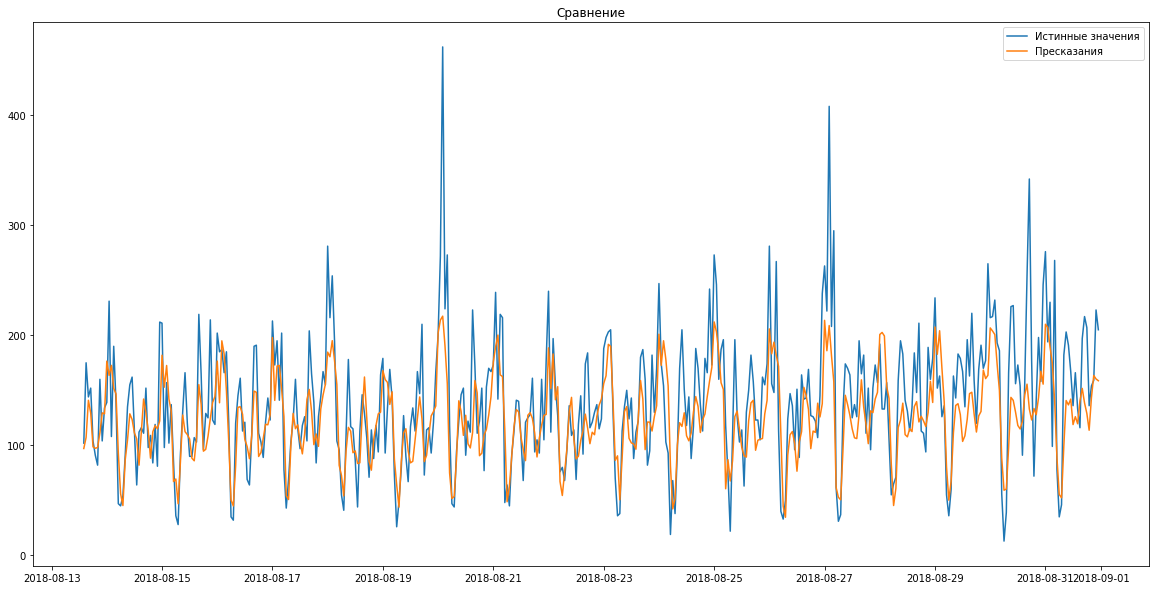

In [22]:
# добавил
plt.figure(figsize = (20, 10))

plt.plot(target_test, label = 'Истинные значения')
plt.plot(target_test.index, predict_lgb_test, label = 'Пресказания')

plt.title('Сравнение')
plt.legend();

__ВЫВОД__

Мы выполнили указанное задание 

" Постройте модель для предсказания. Значение метрики RMSE на тестовой выборке должно быть не больше 48."

Модель LGBMRegressor показала RMSE на тестовой выборке - 42.44